In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppression des alertes pour une présentation propre
warnings.filterwarnings("ignore")

# =============================================================================
# BLOC 1 : CHARGEMENT, NETTOYAGE ET CORRECTION DES DONNÉES   
# =============================================================================

file_path = 'données rte 2023.csv'

# Chargement robuste (Gestion automatique des séparateurs , ou ; et encodage)
try:
    # Tentative standard (séparateur virgule souvent issu d'Excel FR converti)
    df_raw = pd.read_csv(file_path, sep=',', encoding='utf-8-sig', low_memory=False)
    
    # Si le séparateur était mauvais, tout est dans une seule colonne -> on retente avec ;
    if len(df_raw.columns) < 5: 
        df_raw = pd.read_csv(file_path, sep=';', encoding='utf-8-sig', low_memory=False)
except:
    # Fallback pour les anciens fichiers
    df_raw = pd.read_csv(file_path, sep=';', encoding='latin-1', low_memory=False)

# Standardisation des colonnes
df_raw.columns = df_raw.columns.str.strip()
df_raw = df_raw.rename(columns={'ï»¿Perimetre': 'Perimetre', 'Périmètre': 'Perimetre'})

#  Filtrage Périmètre
if 'Perimetre' in df_raw.columns:
    df_raw = df_raw[df_raw['Perimetre'] == 'France'].copy()

# Création de l'index temporel
df_raw['Datetime'] = pd.to_datetime(df_raw['Date'] + ' ' + df_raw['Heures'], dayfirst=True, errors='coerce')
df_raw = df_raw.dropna(subset=['Datetime']).set_index('Datetime').sort_index()

# Correction Data Quality : Suppression des "Faux Zéros"
cols_a_corriger = [
    'Consommation', 'Nucleaire', 'Hydraulique', 
    'Eolien', 'Solaire', 'Gaz', 'Charbon', 'Fioul', 'Bioenergies'
]

for col in cols_a_corriger:
    if col in df_raw.columns:
        # Conversion numérique
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
        df_raw[col] = df_raw[col].replace(0, np.nan).interpolate(method='linear', limit_direction='both').fillna(0)

print(f"Données chargées : {df_raw.shape[0]} lignes. Période : {df_raw.index.min()} au {df_raw.index.max()}")
print(f"Aperçu :\n{df_raw.head(3)}")

Données chargées : 35040 lignes. Période : 2023-01-01 00:00:00 au 2023-12-31 23:45:00
Aperçu :
                    Perimetre               Nature    Date Heures  \
Datetime                                                            
2023-01-01 00:00:00    France  Donnees definitives  1/1/23   0:00   
2023-01-01 00:15:00    France  Donnees definitives  1/1/23   0:15   
2023-01-01 00:30:00    France  Donnees definitives  1/1/23   0:30   

                     Consommation  Prevision J-1  Prevision J  Fioul  Charbon  \
Datetime                                                                        
2023-01-01 00:00:00       47571.0        46600.0      48000.0   81.0     24.0   
2023-01-01 00:15:00       46956.5        46050.0      47500.0   74.5     24.0   
2023-01-01 00:30:00       46342.0        45500.0      47000.0   68.0     24.0   

                        Gaz  ...  Hydraulique - Fil de l?eau + eclusee  \
Datetime                     ...                                         
2023-

In [ ]:
# =============================================================================
# BLOC 2 : PRÉPARATION DES DONNÉES DE MARCHÉ (FUSION PRIX/VOLUME)
# =============================================================================

# Chargement du fichier des Prix Spot
file_prices = 'GUI_ENERGY_PRICES_202212312300-202312312300 (1).csv'
df_prices = pd.read_csv(file_prices)

# Nettoyage des Prix
# On extrait la date de début de l'heure (Ex: "01/01/2023 00:00 - ...")
df_prices['Datetime'] = pd.to_datetime(df_prices['MTU (CET/CEST)'].str.split(' - ').str[0], dayfirst=True, errors='coerce')
df_prices = df_prices.set_index('Datetime').sort_index()

# On ne garde que la colonne utile et on la renomme
df_prices = df_prices[['Day-ahead Price (EUR/MWh)']].rename(columns={'Day-ahead Price (EUR/MWh)': 'Spot_Price'})
df_prices['Spot_Price'] = pd.to_numeric(df_prices['Spot_Price'], errors='coerce')

# Préparation de la Production (Passage de 15 min à 1 Heure)
# On prend la moyenne horaire pour s'aligner avec les prix
cols_market = ['Solaire', 'Eolien', 'Consommation'] 
# Sécurité : on ne prend que les colonnes qui existent dans df_raw
cols_market = [c for c in cols_market if c in df_raw.columns]
df_hourly = df_raw[cols_market].resample('H').mean()

# Fusion Finale (Merge)
# 'inner' ne garde que les heures communes aux deux fichiers
df_market_clean = df_hourly.join(df_prices, how='inner')

print(f"Dataset Financier prêt : {len(df_market_clean)} heures.")
print(f"Aperçu :\n{df_market_clean.head(3)}")

Dataset Financier prêt : 8756 heures.
Aperçu :
                     Solaire     Eolien  Consommation  Spot_Price
Datetime                                                         
2023-01-01 00:00:00     10.0  14373.875     46608.875        0.00
2023-01-01 01:00:00     10.0  11026.500     45090.000       -0.10
2023-01-01 02:00:00     10.0  10287.000     44632.125       -1.33


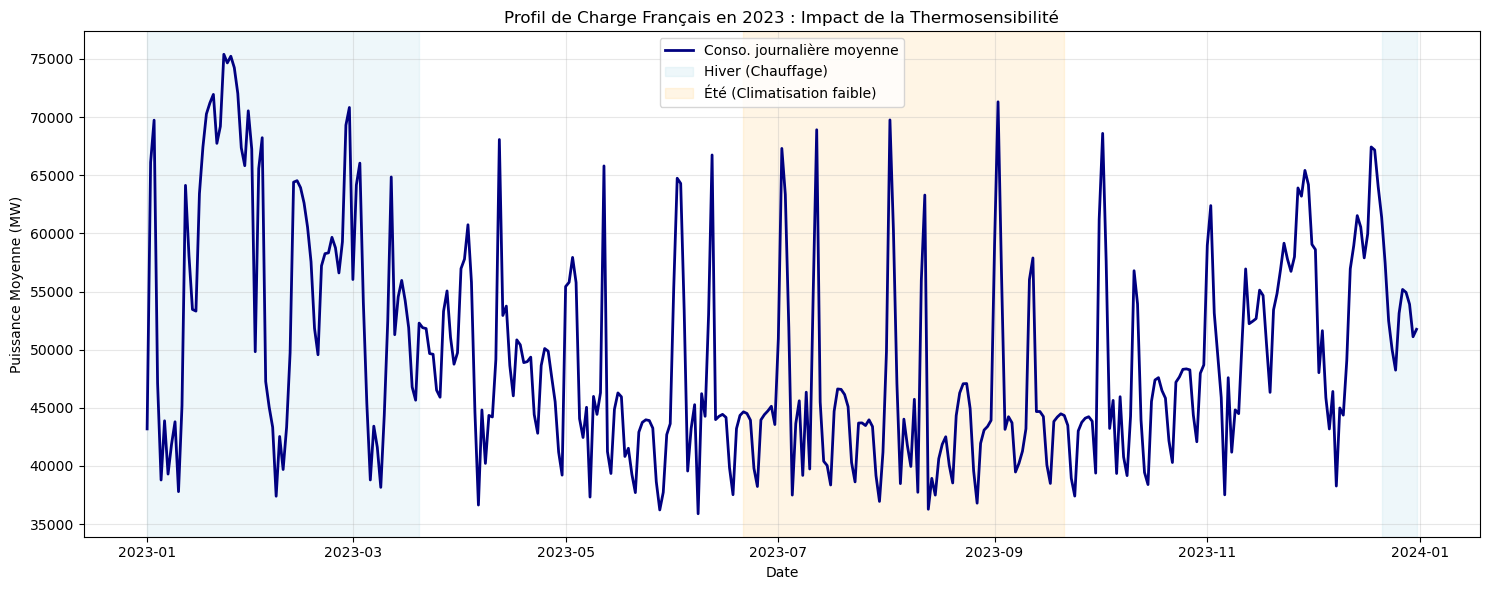

------------------------------
ANALYSE DE LA SAISONNALITÉ :
Moyenne Hiver (Janvier) : 60,306 MW
Moyenne Été (Juillet)   : 45,717 MW
Delta de consommation   : 14,589 MW (soit +31.9% en hiver)
------------------------------


In [11]:
# =============================================================================
# BLOC 3 : VISUALISATION DE LA THERMOSENSIBILITÉ (Saisonnalité)
# =============================================================================

# Calcul de la moyenne journalière 
df_daily = df_raw['Consommation'].resample('D').mean()

plt.figure(figsize=(15, 6))

# On trace la moyenne journalière 
plt.plot(df_daily.index, df_daily, color='navy', linewidth=2, label='Conso. journalière moyenne')

# Ajout des zones colorées pour visualiser les saisons (Hiver vs Été)
plt.axvspan('2023-01-01', '2023-03-20', color='lightblue', alpha=0.2, label='Hiver (Chauffage)')
plt.axvspan('2023-06-21', '2023-09-21', color='orange', alpha=0.1, label='Été (Climatisation faible)')
plt.axvspan('2023-12-21', '2023-12-31', color='lightblue', alpha=0.2) 

plt.title("Profil de Charge Français en 2023 : Impact de la Thermosensibilité")
plt.xlabel("Date")
plt.ylabel("Puissance Moyenne (MW)")
plt.legend(loc='upper center')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#  STATISTIQUES SAISONNIÈRES (Analyse Quantitative)
# Calcul des moyennes sur les mois représentatifs
try:
    moyenne_janvier = df_raw.loc['2023-01', 'Consommation'].mean()
    moyenne_juillet = df_raw.loc['2023-07', 'Consommation'].mean()
    ecart = moyenne_janvier - moyenne_juillet

    print("-" * 30)
    print("ANALYSE DE LA SAISONNALITÉ :")
    print(f"Moyenne Hiver (Janvier) : {moyenne_janvier:,.0f} MW")
    print(f"Moyenne Été (Juillet)   : {moyenne_juillet:,.0f} MW")
    print(f"Delta de consommation   : {ecart:,.0f} MW (soit +{ecart/moyenne_juillet:.1%} en hiver)")
    print("-" * 30)

except KeyError as e:
    print(f"Erreur de date dans les calculs statistiques : {e}")

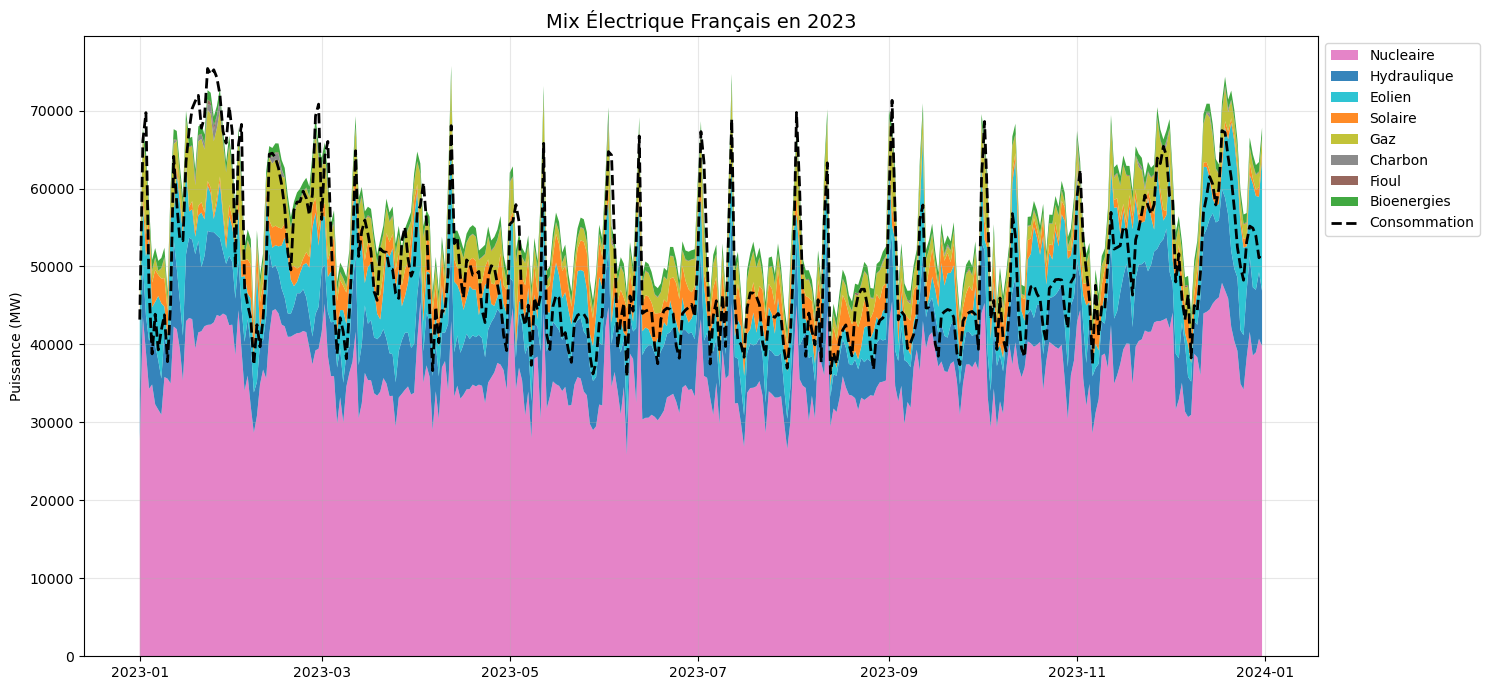

------------------------------
TOTAL PRODUCTION : 56,241 MW
------------------------------


In [13]:
# =============================================================================
# BLOC 4 : ANALYSE DU MIX ÉLECTRIQUE DE PRODUCTION
# =============================================================================

# CORRECTION CRITIQUE : SUPPRESSION DES ZÉROS ARTIFICIELS

# Liste des colonnes de production à nettoyer
cols_prod = [
    'Nucleaire', 'Hydraulique', 'Eolien', 'Solaire', 
    'Gaz', 'Charbon', 'Fioul', 'Bioenergies'
]


for col in cols_prod:
    if col in df_raw.columns:
        # Étape 1 : On remplace les 0 par NaN pour les exclure des calculs temporairement
        # C'est la seule façon de dire à Pandas : "Ce 0 n'est pas une vraie production nulle, c'est une erreur"
        df_raw[col] = df_raw[col].replace(0, np.nan)
        
        # Étape 2 : On interpole linéairement (relie les points valides entre eux)
        df_raw[col] = df_raw[col].interpolate(method='linear', limit_direction='both')
        
        # Étape 3 : Sécurité (si le fichier entier est vide, on remet 0)
        df_raw[col] = df_raw[col].fillna(0)

# Recalcul du Mix Moyen après correction
df_mix_corrected = df_raw[cols_prod].resample('D').mean()

# Vérification immédiate
avg_nuke = df_raw['Nucleaire'].mean()

# --- RE-AFFICHAGE DU GRAPHIQUE CORRIGÉ ---
plt.figure(figsize=(15, 7))

# Palette de couleurs
couleurs = {
    'Nucleaire': '#E377C2',   # Rose
    'Hydraulique': '#1F77B4', # Bleu
    'Bioenergies': '#2CA02C', # Vert
    'Gaz': '#BCBD22',         # Olive
    'Charbon': '#7F7F7F',     # Gris
    'Fioul': '#8C564B',       # Marron
    'Eolien': '#17BECF',      # Cyan
    'Solaire': '#FF7F0E'      # Orange
}
# Filtrage des colonnes présentes
cols_finales = [c for c in cols_prod if c in df_raw.columns]
palette = [couleurs[c] for c in cols_finales]

plt.stackplot(df_mix_corrected.index, df_mix_corrected[cols_finales].T, 
              labels=cols_finales, colors=palette, alpha=0.9)

# Ajout de la Conso
plt.plot(df_daily.index, df_daily, color='black', linewidth=2, linestyle='--', label='Consommation')

plt.title("Mix Électrique Français en 2023", fontsize=14)
plt.ylabel("Puissance (MW)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("-" * 30)
print(f"TOTAL PRODUCTION : {df_mix_corrected.sum(axis=1).mean():,.0f} MW")
print("-" * 30)

------------------------------
ANALYSE DE LA POINTE ÉLECTRIQUE :
Puissance Max Appelée : 83,757 MW
Date de survenance    : 23/01/2023 à 19:00
------------------------------


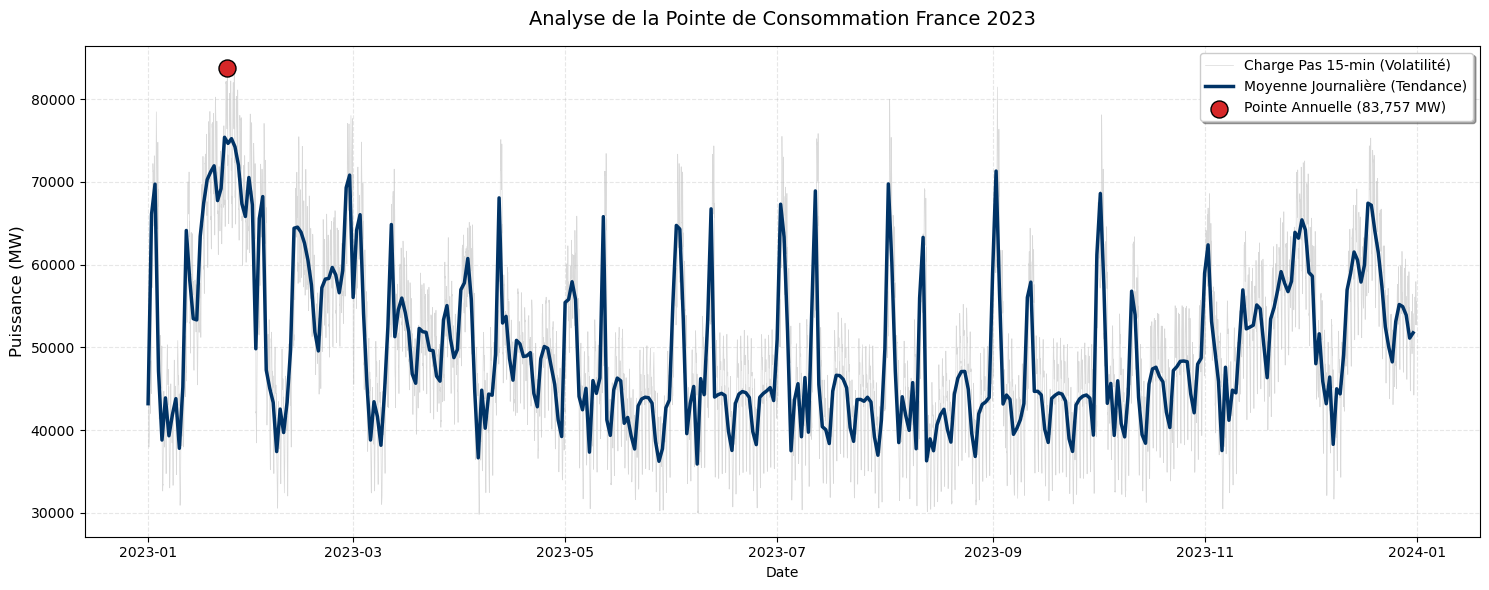

------------------------------
ANALYSE DU MOMENT CRITIQUE (PIC) :
 Date du Pic       : 2023-01-23 19:00:00
 Charge Maximale   : 83,757 MW
 Prix à cet instant: 223.19 €/MWh
 Prod. Locale      : 79,699 MW
 DÉPENDANCE        : La France IMPORTAIT 4,058 MW à ce moment-là !


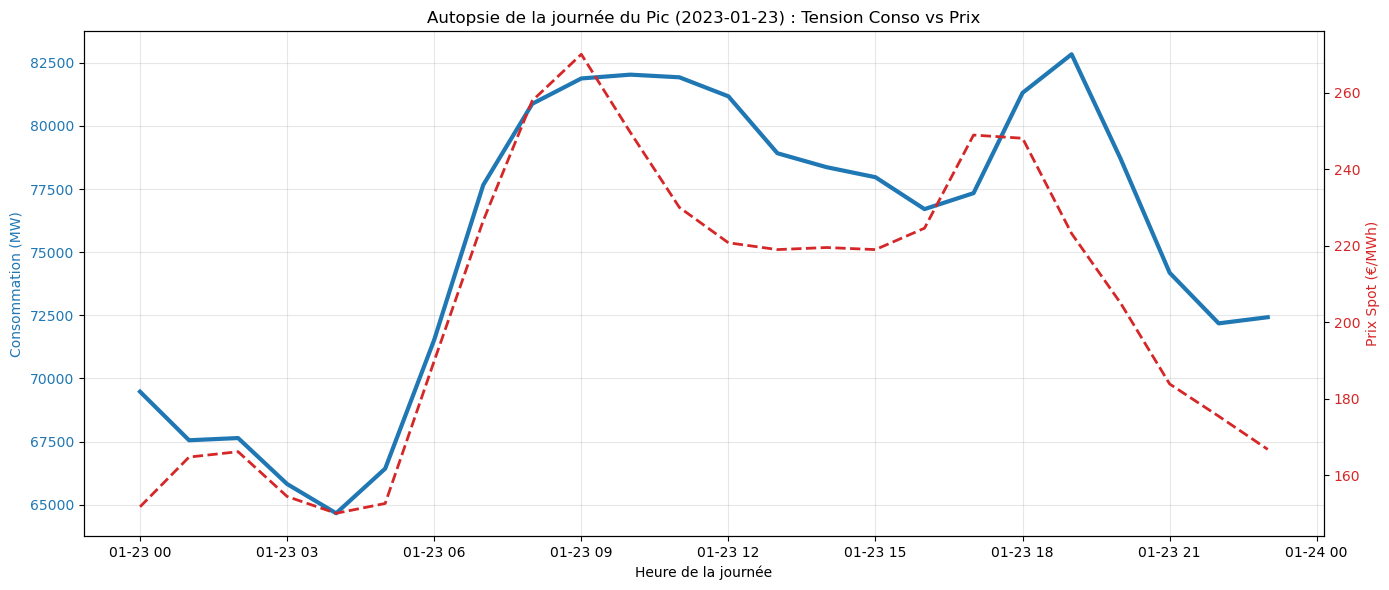

In [5]:
# =============================================================================
# BLOC 5 : ANALYSE DU PIC DE CHARGE (POINTE DE CONSOMMATION) ET ZOOM SUR LE "STRESS TEST" (LE PIC ANNUEL)
# =============================================================================

# Recherche de la valeur maximale exacte et de l'horaire associé dans les données brutes (15 min)
pic_max = df_raw['Consommation'].max()
date_pic = df_raw['Consommation'].idxmax()

# Affichage propre pour rapport
print("-" * 30)
print("ANALYSE DE LA POINTE ÉLECTRIQUE :")
print(f"Puissance Max Appelée : {pic_max:,.0f} MW")
# .strftime permet un formatage lisible : "12 Janvier 2023 à 19:00"
print(f"Date de survenance    : {date_pic.strftime('%d/%m/%Y à %H:%M')}")
print("-" * 30)

# Visualisation : Comparaison Volatilité vs Tendance
plt.figure(figsize=(15, 6))

# 1. On trace la donnée brute en arrière-plan (Gris léger)
# Cela montre la volatilité intra-journalière (les pics matin/soir)
plt.plot(df_raw.index, df_raw['Consommation'], 
         color='silver', alpha=0.6, linewidth=0.5, 
         label='Charge Pas 15-min (Volatilité)')

# 2. On trace la moyenne journalière par dessus (Bleu foncé)
# Cela montre la tendance saisonnière (Thermosensibilité)
plt.plot(df_daily.index, df_daily, 
         color='#003366', linewidth=2.5, # Bleu "Institutionnel"
         label='Moyenne Journalière (Tendance)')

# 3. Mise en évidence du Pic Absolu (Point Rouge)
plt.scatter(date_pic, pic_max, 
            color='#D62728', s=150, zorder=5, edgecolors='black', 
            label=f'Pointe Annuelle ({pic_max:,.0f} MW)')

# Esthétique professionnelle
plt.title(f"Analyse de la Pointe de Consommation France 2023", fontsize=14, pad=15)
plt.ylabel("Puissance (MW)", fontsize=12)
plt.xlabel("Date")
plt.legend(loc='upper right', frameon=True, shadow=True) # Légende avec ombre pour lisibilité
plt.grid(True, which='major', alpha=0.3, linestyle='--')
plt.tight_layout()

plt.show()

print("-" * 30)
print("ANALYSE DU MOMENT CRITIQUE (PIC) :")

# 1. Identification précise du Pic
idx_pic = df_raw['Consommation'].idxmax()
val_pic = df_raw.loc[idx_pic, 'Consommation']
date_jour_pic = idx_pic.strftime('%Y-%m-%d')

# 2. Récupération des données à cet instant T
# On doit gérer l'arrondi à l'heure pour trouver le prix correspondant (car prix = pas horaire)
idx_pic_hourly = idx_pic.round('h') 
# Sécurité si l'arrondi nous sort de l'index
try:
    prix_au_pic = df_prices.loc[idx_pic_hourly, 'Spot_Price']
except KeyError:
    # Si l'heure exacte manque, on prend l'heure d'avant
    prix_au_pic = df_prices.loc[idx_pic_hourly - pd.Timedelta(hours=1), 'Spot_Price']

# 3. Calcul du "Bilan Physique" à l'instant du pic
prod_totale_pic = df_raw.loc[idx_pic, cols_prod].sum()
solde_import = val_pic - prod_totale_pic # Si positif = On importe

print(f" Date du Pic       : {idx_pic}")
print(f" Charge Maximale   : {val_pic:,.0f} MW")
print(f" Prix à cet instant: {prix_au_pic:.2f} €/MWh")
print(f" Prod. Locale      : {prod_totale_pic:,.0f} MW")

if solde_import > 0:
    print(f" DÉPENDANCE        : La France IMPORTAIT {solde_import:,.0f} MW à ce moment-là !")
else:
    print(f" SOUVERAINETÉ      : La France EXPORTAIT {abs(solde_import):,.0f} MW malgré le pic.")

# 4. Visualisation de la "Journée de tous les dangers"
# On filtre les données sur les 24h entourant le pic
df_zoom = df_market_clean.loc[date_jour_pic]

fig, ax1 = plt.subplots(figsize=(14, 6))

# Axe Gauche : Consommation
color = 'tab:blue'
ax1.set_xlabel('Heure de la journée')
ax1.set_ylabel('Consommation (MW)', color=color)
ax1.plot(df_zoom.index, df_zoom['Consommation'], color=color, linewidth=3, label='Consommation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Axe Droit : Prix
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Prix Spot (€/MWh)', color=color)
ax2.plot(df_zoom.index, df_zoom['Spot_Price'], color=color, linestyle='--', linewidth=2, label='Prix Spot')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Autopsie de la journée du Pic ({date_jour_pic}) : Tension Conso vs Prix")
fig.tight_layout()
plt.show()



Ce graphique prouve que le prix de l'électricité n'est pas dicté par la consommation brute, mais par la Charge Résiduelle. Ici, les énergies renouvelables ont joué leur rôle d'amortisseur : elles ont comblé une partie du pic de demande, empêchant ainsi le prix de flamber.

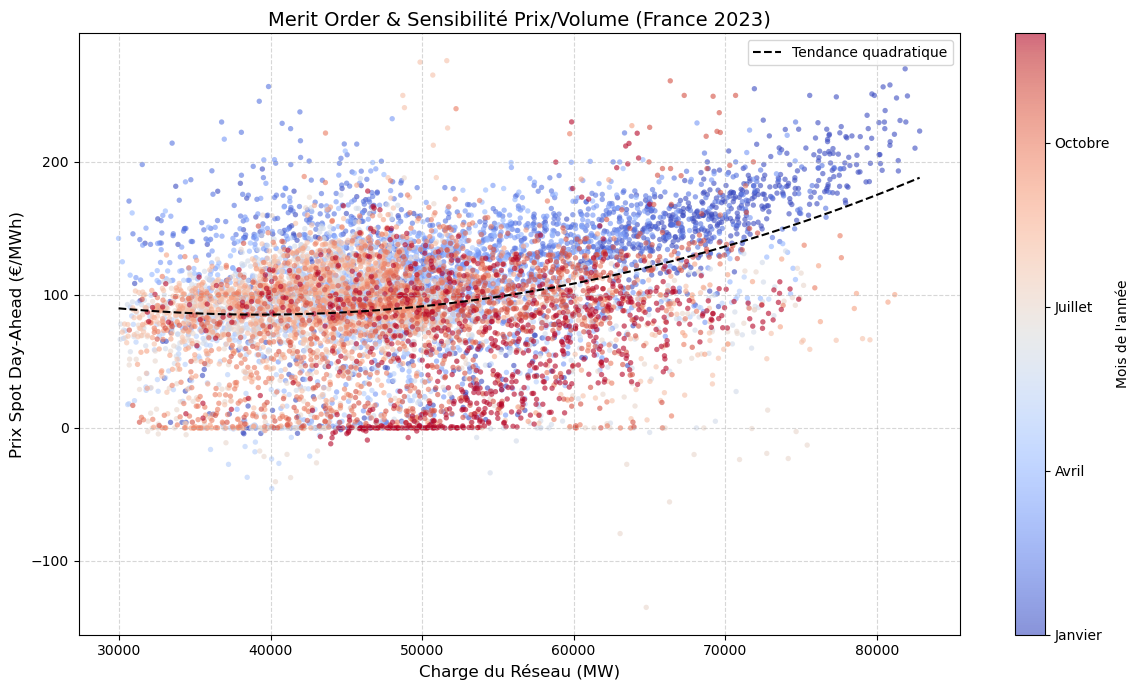

Corrélation Globale (Conso vs Prix) : 32.90%
Nombre d'heures à prix négatifs : 147 h
Moyenne Conso durant prix négatifs : 46700 MW
Moyenne Eolien durant prix négatifs : 6442 MW


In [6]:
# =============================================================================
# BLOC 6 : ANALYSE DE LA CORRÉLATION CONSOMMATION VS PRIX
# =============================================================================

plt.figure(figsize=(12, 7))

# Scatter Plot avec couleur selon le mois (Saisonnalité)
sc = plt.scatter(
    df_market_clean['Consommation'], 
    df_market_clean['Spot_Price'], 
    c=df_market_clean.index.month, 
    cmap='coolwarm', # Bleu (Hiver) -> Rouge (Été)... attention ici c'est Mois 1->12
    alpha=0.6, 
    edgecolors='none',
    s=15
)

# Ajout d'une courbe de tendance (Régression polynomiale simple pour visualiser l'effet "Hockey Stick")
# Optionnel mais très apprécié
import numpy as np
z = np.polyfit(df_market_clean['Consommation'], df_market_clean['Spot_Price'], 2) # Degré 2
p = np.poly1d(z)
x_trend = np.linspace(df_market_clean['Consommation'].min(), df_market_clean['Consommation'].max(), 100)
plt.plot(x_trend, p(x_trend), "k--", linewidth=1.5, label='Tendance quadratique')

# Esthétique
plt.title("Merit Order & Sensibilité Prix/Volume (France 2023)", fontsize=14)
plt.xlabel("Charge du Réseau (MW)", fontsize=12)
plt.ylabel("Prix Spot Day-Ahead (€/MWh)", fontsize=12)

# Barre de couleur pour les mois
cbar = plt.colorbar(sc)
cbar.set_label('Mois de l\'année')
cbar.set_ticks([1, 4, 7, 10])
cbar.set_ticklabels(['Janvier', 'Avril', 'Juillet', 'Octobre'])

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# ---  CALCULS STATISTIQUES ---
correlation = df_market_clean['Consommation'].corr(df_market_clean['Spot_Price'])
print(f"Corrélation Globale (Conso vs Prix) : {correlation:.2%}")

# Analyse des prix négatifs 
prix_negatifs = df_market_clean[df_market_clean['Spot_Price'] < 0]
nb_heures_neg = len(prix_negatifs)
print(f"Nombre d'heures à prix négatifs : {nb_heures_neg} h")

if nb_heures_neg > 0:
    # Corrélation spécifique durant les prix négatifs (souvent liée au Solaire/Eolien fort + Conso faible)
    print("Moyenne Conso durant prix négatifs : {:.0f} MW".format(prix_negatifs['Consommation'].mean()))
    print("Moyenne Eolien durant prix négatifs : {:.0f} MW".format(prix_negatifs['Eolien'].mean() if 'Eolien' in prix_negatifs else 0))

--- CALCUL DES PRIX DE CAPTURE (MÉTHODE VECTORISÉE) ---


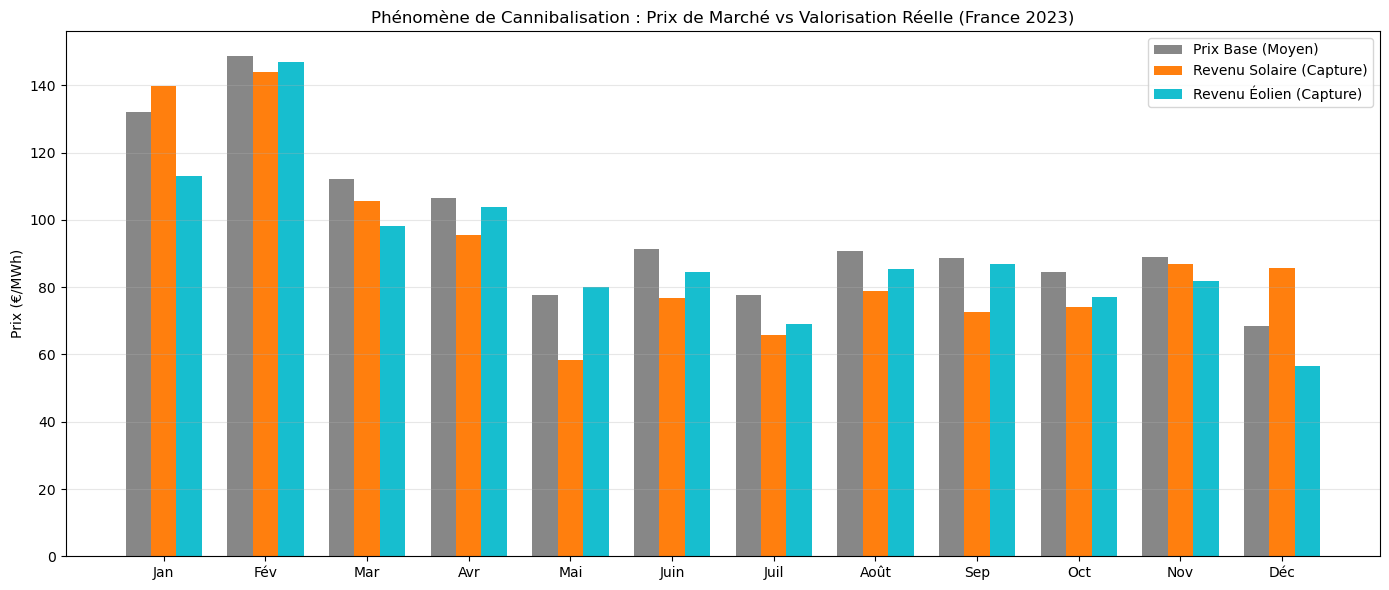

--------------------------------------------------
RAPPORT DE PERFORMANCE ÉCONOMIQUE (FRANCE 2023)
--------------------------------------------------
PRIX SPOT MOYEN (BASELOAD)  : 96.89 €/MWh
--------------------------------------------------
VALEUR RÉELLE SOLAIRE       : 85.95 €/MWh
-> DÉCOTE SOLAIRE           : -11.29%
--------------------------------------------------
VALEUR RÉELLE ÉOLIEN        : 89.57 €/MWh
-> DÉCOTE ÉOLIEN            : -7.55%
--------------------------------------------------


In [7]:
# =============================================================================
# BLOC 7 : ANALYSE FINANCIÈRE
# =============================================================================

print("--- CALCUL DES PRIX DE CAPTURE (MÉTHODE VECTORISÉE) ---")

# 1. On s'assure d'avoir le mois en colonne
df_market_clean['Month'] = df_market_clean.index.month

# 2. Calcul des Flux Financiers (Cash Flows) heure par heure
# Concept : Revenu (€) = Prix (€/MWh) * Volume (MWh)
df_market_clean['Revenu_Solaire'] = df_market_clean['Spot_Price'] * df_market_clean['Solaire']
df_market_clean['Revenu_Eolien']  = df_market_clean['Spot_Price'] * df_market_clean['Eolien']

# 3. Agrégation Mensuelle (Groupby + Sum)
# On somme les revenus et les volumes par mois en une seule opération
monthly_data = df_market_clean.groupby('Month')[
    ['Revenu_Solaire', 'Solaire', 'Revenu_Eolien', 'Eolien']
].sum()

# 4. Calcul des Prix Moyens Pondérés (VWAP - Volume Weighted Average Price)
# Prix Capture = Somme des Revenus / Somme des Volumes
# .fillna(0) gère le cas où la production mensuelle serait nulle
solar_capture = (monthly_data['Revenu_Solaire'] / monthly_data['Solaire']).fillna(0)
wind_capture  = (monthly_data['Revenu_Eolien'] / monthly_data['Eolien']).fillna(0)

# 5. Calcul du Prix Base (Moyenne arithmétique simple)
# Pour le BaseLoad, on prend la moyenne du prix, pas la somme
base_prices = df_market_clean.groupby('Month')['Spot_Price'].mean()

# --- VISUALISATION (Code identique au précédent, mais utilisant les nouvelles variables) ---
plt.figure(figsize=(14, 6))

mois_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
x = np.arange(len(mois_labels))
width = 0.25

# Barres
plt.bar(x - width, base_prices, width, label='Prix Base (Moyen)', color='#555555', alpha=0.7)
plt.bar(x, solar_capture, width, label='Revenu Solaire (Capture)', color='#FF7F0E') # Orange
plt.bar(x + width, wind_capture, width, label='Revenu Éolien (Capture)', color='#17BECF') # Cyan

plt.ylabel('Prix (€/MWh)')
plt.title('Phénomène de Cannibalisation : Prix de Marché vs Valorisation Réelle (France 2023)')
plt.xticks(x, mois_labels)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --- CALCUL DES KPIS GLOBAUX POUR L'ANALYSE ---
# On utilise la même logique vectorisée sur l'année entière
avg_base = df_market_clean['Spot_Price'].mean()

# Somme totale Revenus / Somme totale Volume
avg_solar = df_market_clean['Revenu_Solaire'].sum() / df_market_clean['Solaire'].sum()
avg_wind  = df_market_clean['Revenu_Eolien'].sum() / df_market_clean['Eolien'].sum()

decote_solaire = (1 - avg_solar / avg_base) * 100
decote_eolien  = (1 - avg_wind / avg_base) * 100

print("-" * 50)
print("RAPPORT DE PERFORMANCE ÉCONOMIQUE (FRANCE 2023)")
print("-" * 50)
print(f"PRIX SPOT MOYEN (BASELOAD)  : {avg_base:.2f} €/MWh")
print("-" * 50)
print(f"VALEUR RÉELLE SOLAIRE       : {avg_solar:.2f} €/MWh")
print(f"-> DÉCOTE SOLAIRE           : -{decote_solaire:.2f}%")
print("-" * 50)
print(f"VALEUR RÉELLE ÉOLIEN        : {avg_wind:.2f} €/MWh")
print(f"-> DÉCOTE ÉOLIEN            : -{decote_eolien:.2f}%")
print("-" * 50)

--- HYPOTHÈSES DE MODÉLISATION (10 MW installés) ---
Strike PPA Solaire : 65 €/MWh
Strike PPA Éolien  : 75 €/MWh
--------------------------------------------------

--- RÉSULTATS DE PERFORMANCE ANNUELLE ---
STRATÉGIE            | REVENU SOLAIRE (€)   | REVENU ÉOLIEN (€)    | DIFFÉRENTIEL (€)
-------------------------------------------------------------------------------------
Merchant             | 1,436,614 €         | 2,495,199 €          | +1,058,586 €
PPA                  | 1,086,411 €         | 2,089,295 €          | +1,002,884 €
Mixte                | 1,191,472 €         | 2,211,066 €          | +1,019,594 €
-------------------------------------------------------------------------------------


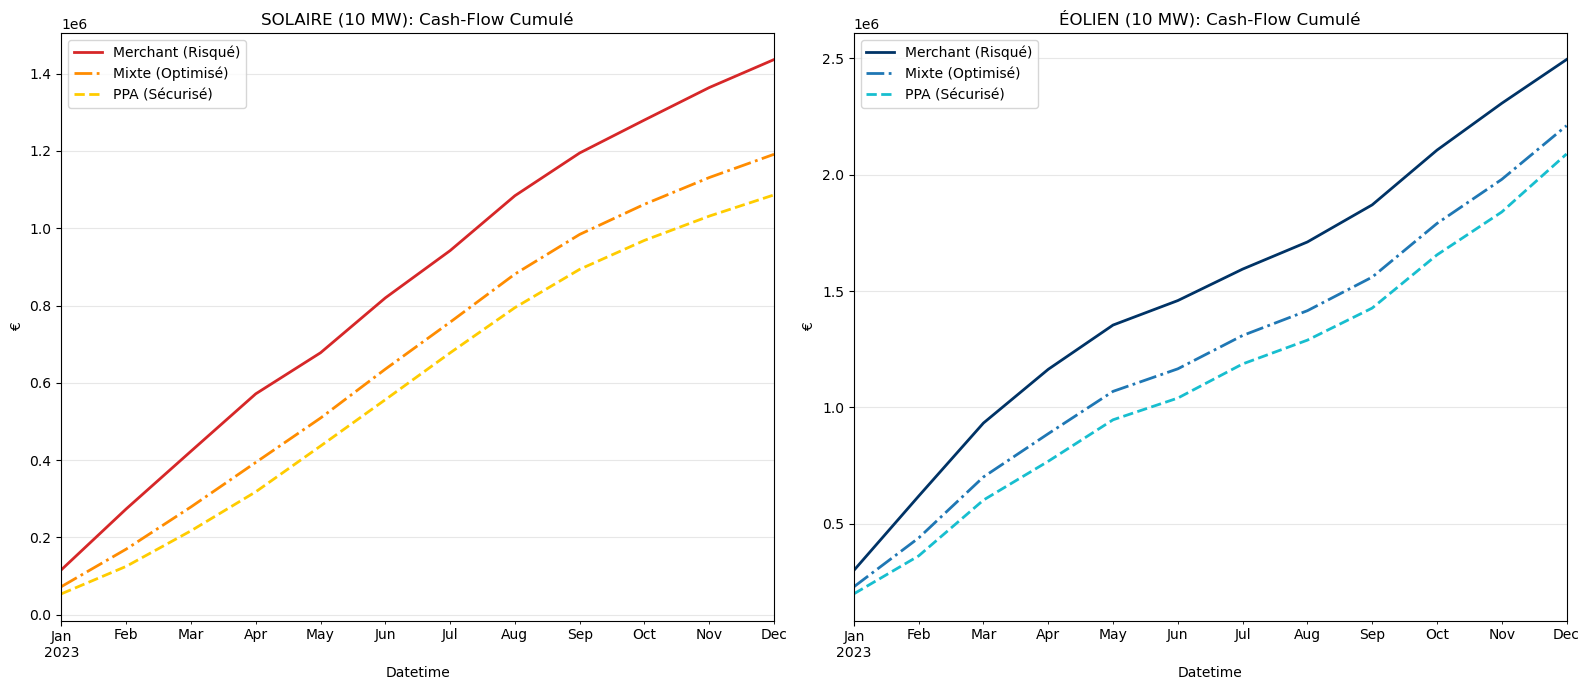


[ANALYSE] VERDICT PAR SCÉNARIO :
-> Merchant   : Vainqueur = ÉOLIEN
-> PPA        : Vainqueur = ÉOLIEN
-> Mixte      : Vainqueur = ÉOLIEN

--- KPI DE RISQUE (VOLATILITÉ MENSUELLE) ---
STRATÉGIE            | RISQUE SOLAIRE       | RISQUE ÉOLIEN        | REDUCTION RISQUE
-------------------------------------------------------------------------------------
Merchant             | 28,750 €            | 74,196 €             | REF
Mixte                | 23,500 €            | 52,228 €             | -30%
PPA                  | 26,036 €            | 50,093 €             | -32%
-------------------------------------------------------------------------------------


In [8]:
# =============================================================================
# BLOC 8 : ANALYSE DE PORTEFEUILLE SOLAIRE vs ÉOLIEN (HEDGING & PERFORMANCE)
# =============================================================================

# Hypothèses de marché basées sur les standards CRE/PPA 2023

# --- 1. PARAMÈTRES DE LA SIMULATION ---
CAPACITE_MW = 10  # Taille standard parc
PRIX_PPA_SOLAIRE = 65  # €/MWh
PRIX_PPA_EOLIEN  = 75  # €/MWh

print(f"--- HYPOTHÈSES DE MODÉLISATION ({CAPACITE_MW} MW installés) ---")
print(f"Strike PPA Solaire : {PRIX_PPA_SOLAIRE} €/MWh")
print(f"Strike PPA Éolien  : {PRIX_PPA_EOLIEN} €/MWh")
print("-" * 50)

# --- 2. CALCUL DES FLUX FINANCIERS (CASH FLOWS) ---
# Normalisation
prod_solaire_norm = (df_market_clean['Solaire'] / df_market_clean['Solaire'].max()) * CAPACITE_MW
prod_eolien_norm  = (df_market_clean['Eolien'] / df_market_clean['Eolien'].max()) * CAPACITE_MW

# A. Stratégie MERCHANT (100% Spot)
rev_merchant_sol = prod_solaire_norm * df_market_clean['Spot_Price']
rev_merchant_wind = prod_eolien_norm * df_market_clean['Spot_Price']

# B. Stratégie PPA (100% Fixe)
rev_ppa_sol = prod_solaire_norm * PRIX_PPA_SOLAIRE
rev_ppa_wind = prod_eolien_norm * PRIX_PPA_EOLIEN

# C. Stratégie MIXTE (70% PPA / 30% Spot)
RATIO_HEDGE = 0.7
rev_mixte_sol = (rev_ppa_sol * RATIO_HEDGE) + (rev_merchant_sol * (1 - RATIO_HEDGE))
rev_mixte_wind = (rev_ppa_wind * RATIO_HEDGE) + (rev_merchant_wind * (1 - RATIO_HEDGE))

# --- 3. CONSOLIDATION DES RÉSULTATS ---
resultats = pd.DataFrame({
    'Solaire - Merchant': rev_merchant_sol.sum(),
    'Solaire - PPA': rev_ppa_sol.sum(),
    'Solaire - Mixte': rev_mixte_sol.sum(),
    'Eolien - Merchant': rev_merchant_wind.sum(),
    'Eolien - PPA': rev_ppa_wind.sum(),
    'Eolien - Mixte': rev_mixte_wind.sum()
}, index=['Revenu Annuel (€)'])

# --- 4. TABLEAU DE BORD ---
print("\n--- RÉSULTATS DE PERFORMANCE ANNUELLE ---")
print(f"{'STRATÉGIE':<20} | {'REVENU SOLAIRE (€)':<20} | {'REVENU ÉOLIEN (€)':<20} | {'DIFFÉRENTIEL (€)'}")
print("-" * 85)

strategies = ['Merchant', 'PPA', 'Mixte']
for strat in strategies:
    val_sol = resultats.loc['Revenu Annuel (€)', f'Solaire - {strat}']
    val_wind = resultats.loc['Revenu Annuel (€)', f'Eolien - {strat}']
    diff = val_wind - val_sol
    
    print(f"{strat:<20} | {val_sol:,.0f} €".ljust(43) + f"| {val_wind:,.0f} €".ljust(23) + f"| {diff:+,.0f} €")

print("-" * 85)

# --- 5. VISUALISATION COMPARATIVE (MISE À JOUR AVEC 3 SCÉNARIOS) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Solaire : On intègre Mixte
monthly_rev_sol = pd.DataFrame({
    'Merchant (Risqué)': rev_merchant_sol.resample('ME').sum(),
    'Mixte (Optimisé)': rev_mixte_sol.resample('ME').sum(), # Ajouté
    'PPA (Sécurisé)': rev_ppa_sol.resample('ME').sum()
}).cumsum()

# Couleurs Solaire : Rouge -> Orange -> Jaune Pâle
monthly_rev_sol.plot(ax=ax1, color=['#d62728', '#FF8C00', '#FFCC00'], linewidth=2, style=['-', '-.', '--'])
ax1.set_title(f"SOLAIRE ({CAPACITE_MW} MW): Cash-Flow Cumulé")
ax1.set_ylabel("€")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Éolien : On intègre Mixte
monthly_rev_wind = pd.DataFrame({
    'Merchant (Risqué)': rev_merchant_wind.resample('ME').sum(),
    'Mixte (Optimisé)': rev_mixte_wind.resample('ME').sum(), # Ajouté
    'PPA (Sécurisé)': rev_ppa_wind.resample('ME').sum()
}).cumsum()

# Couleurs Éolien : Bleu Foncé -> Bleu Moyen -> Cyan
monthly_rev_wind.plot(ax=ax2, color=['#003366', '#1F77B4', '#17BECF'], linewidth=2, style=['-', '-.', '--'])
ax2.set_title(f"ÉOLIEN ({CAPACITE_MW} MW): Cash-Flow Cumulé")
ax2.set_ylabel("€")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# --- 6. INTERPRÉTATION AUTOMATIQUE ---
print("\n[ANALYSE] VERDICT PAR SCÉNARIO :")
wins_wind = 0
for strat in strategies:
    rev_s = resultats.loc['Revenu Annuel (€)', f'Solaire - {strat}']
    rev_w = resultats.loc['Revenu Annuel (€)', f'Eolien - {strat}']
    
    if rev_w > rev_s:
        wins_wind += 1
        winner = "ÉOLIEN"
    else:
        winner = "SOLAIRE"
        
    print(f"-> {strat:<10} : Vainqueur = {winner}")

# --- 3. ANALYSE DE RISQUE (Volatilité Mensuelle) ---
print("\n--- KPI DE RISQUE (VOLATILITÉ MENSUELLE) ---")
print(f"{'STRATÉGIE':<20} | {'RISQUE SOLAIRE':<20} | {'RISQUE ÉOLIEN':<20} | {'REDUCTION RISQUE'}")
print("-" * 85)

# Agrégation mensuelle des revenus (Nécessaire pour le calcul de l'écart-type)
monthly_sol = pd.DataFrame({
    'Merchant': rev_merchant_sol.resample('ME').sum(), 
    'Mixte': rev_mixte_sol.resample('ME').sum(), 
    'PPA': rev_ppa_sol.resample('ME').sum()
})

monthly_wind = pd.DataFrame({
    'Merchant': rev_merchant_wind.resample('ME').sum(), 
    'Mixte': rev_mixte_wind.resample('ME').sum(), 
    'PPA': rev_ppa_wind.resample('ME').sum()
})

# Calcul de la volatilité (Standard Deviation)
vol_sol = monthly_sol.std()
vol_wind = monthly_wind.std()

for strat in ['Merchant', 'Mixte', 'PPA']:
    v_s = vol_sol[strat]
    v_w = vol_wind[strat]
    
    # Calcul de la réduction de risque par rapport au Spot (Benchmark Éolien)
    ref_risk_w = vol_wind['Merchant']
    reduc_w = (1 - v_w/ref_risk_w) if ref_risk_w > 0 else 0
    
    # Formatage de l'affichage
    risk_txt = f"-{reduc_w:.0%}" if strat != 'Merchant' else "REF"
    
    print(f"{strat:<20} | {v_s:,.0f} €".ljust(43) + f"| {v_w:,.0f} €".ljust(23) + f"| {risk_txt}")

print("-" * 85)    